In [1]:
import pandas as pd
import numpy as np
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.mini_dannce_sync import sync_videos, align_miniscope_to_sixcam


rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

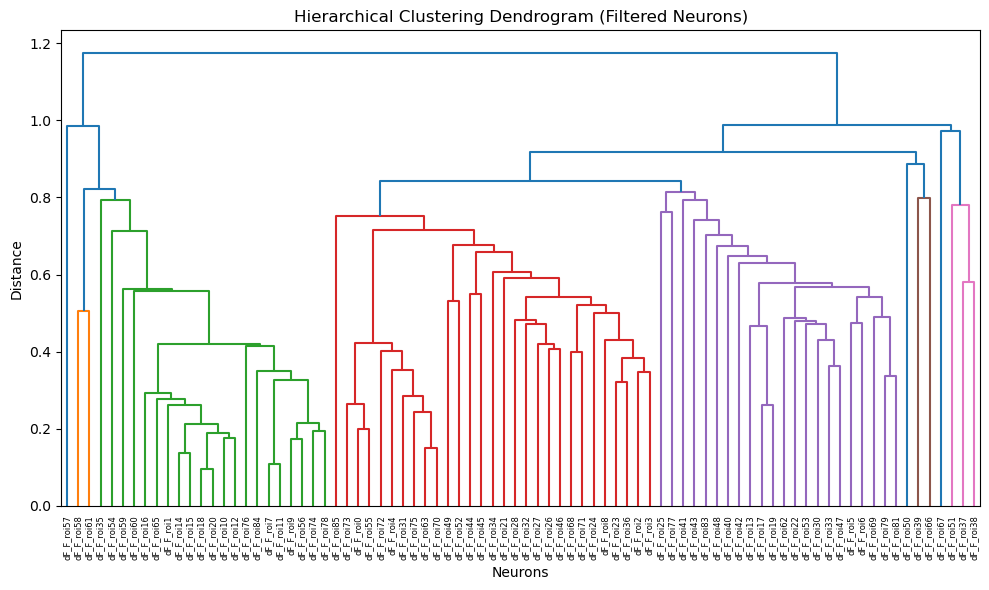

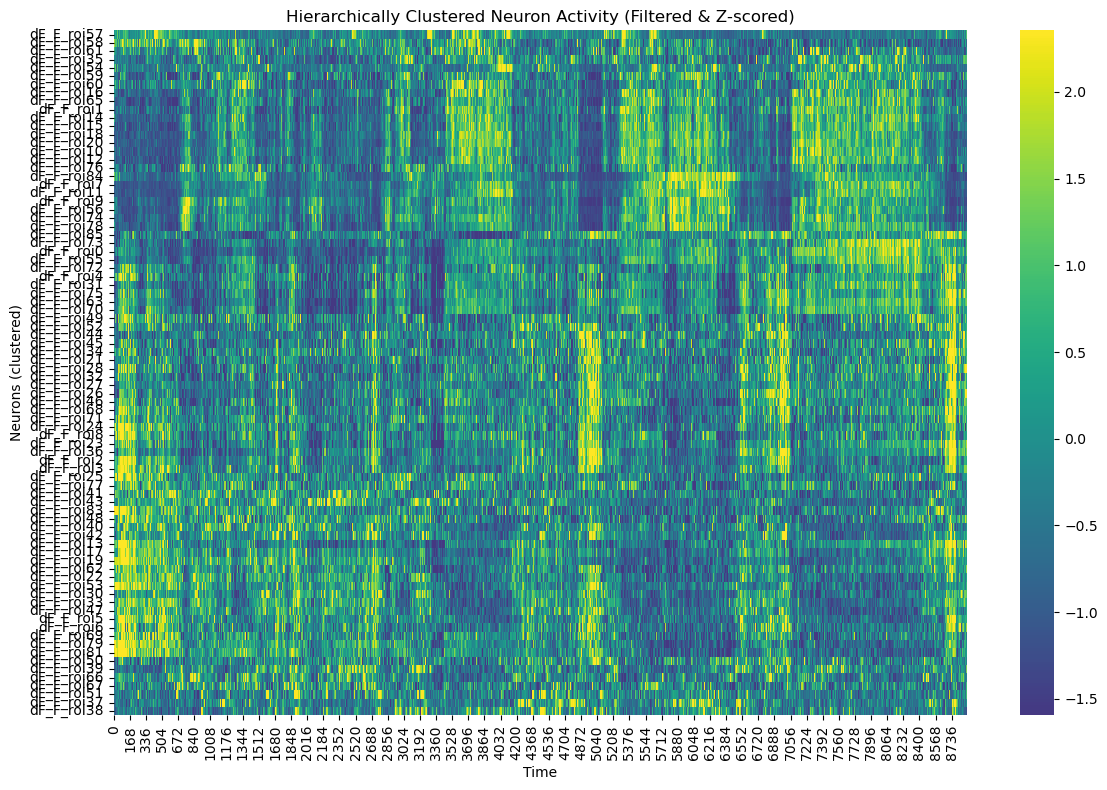

In [4]:
#added the filter low variance step
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')

# Plot the dendrogram to visualize the hierarchical structure
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=filtered_neuron_columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Filtered Neurons)')
plt.xlabel('Neurons')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Get the order of the leaves (neurons) from the dendrogram
neuron_order = leaves_list(Z)

# Reorder filtered and normalized neuron activity and neuron column names
neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

# Plot a heatmap of the clustered neurons
plt.figure(figsize=(12, 8))
sns.heatmap(neuron_activity_ordered, cmap='viridis', center=0, robust=True)
plt.title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
plt.xlabel('Time')
plt.ylabel('Neurons (clustered)')
plt.yticks(np.arange(len(ordered_neuron_columns)) + 0.5, ordered_neuron_columns, rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import os
import sys
sys.path.append(os.path.abspath('../../..'))
from utlis.corr_utlis.adapted_from_dappy import get_angles_from_h5_simple

import pandas as pd
import numpy as np
import plotly.graph_objs as go

# Assuming df_new contains keypoint data and neuron_activity_normalized for neurons
time = df_new.index
"""
IMPORTANT!!! ALL KEYPOINITS START FROM 1, NOT 0! 1-22!!!!!
"""
location_indices_left = [3, 4, 12, 11, 10, 9]
location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

location_indices_right = [3, 4, 16, 15, 14, 13]
location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

# --- NEW PART: Compute Joint Angles ---
# Define triplets for angles: (JointA, JointB (pivot), JointC)
# connectivity = [
#     (12, 11, 10),  # Left side: shoulder-elbow-wrist
#     (16, 15, 14),  # Right side: shoulder-elbow-wrist
#     (4, 12, 11),   # Spine to shoulder to elbow (left)
#     (4, 16, 15)    # Spine to shoulder to elbow (right)
# ]
"""
IMPORTANT!!! ALL KEYPOINITS START FROM 1, NOT 0! 1-22!!!!!
"""
connectivity = [
    (12, 11, 10),  # Left side: shoulder-elbow-wrist
    (16, 15, 14),  # Right side: shoulder-elbow-wrist
    (4, 12, 11),   # Spine to shoulder to elbow (left)
    (4, 16, 15),   # Spine to shoulder to elbow (right)
    (4, 17, 18),   # Spine to hip to knee (left)
    (4, 19, 20),   # Spine to hip to knee (right)
    (11, 10, 9),   # Left elbow to wrist to forepaw
    (15, 14, 13),  # Right elbow to wrist to forepaw
    (3, 4, 12),    # Nose to spine to left shoulder
    (3, 4, 16)     # Nose to spine to right shoulder
]



angles, angle_labels = get_angles_from_h5_simple(df_new, connectivity)
angle_df = pd.DataFrame(angles, columns=angle_labels, index=df_new.index)

# Define angle bins
bin_size = 10
bins = np.arange(0, 190, bin_size)  # 0 to 180 degrees with 10° increments (19 bins)
bin_centers = (bins[:-1] + bins[1:]) / 2  # For plotting the curve at midpoints of bins

# Iterate through all joint angles
for angle_col in angle_labels:
    # Extract the angle time series
    angles = np.degrees(angle_df[angle_col].values)  # Convert to degrees if needed

    # Assign each time point to an angle bin
    bin_indices = np.digitize(angles, bins) - 1  # bin_indices will map each time point to a bin

    # Initialize a Plotly figure
    fig = go.Figure()

    # Iterate through all neurons
    for neuron_idx in range(neuron_activity_normalized.shape[0]):
        # Extract the neuron activity time series
        neuron_response = neuron_activity_normalized[neuron_idx, :]

        # Compute mean activity per bin
        mean_activity_per_bin = []
        for b in range(len(bins)-1):
            responses_in_bin = neuron_response[bin_indices == b]
            if len(responses_in_bin) > 0:
                mean_activity_per_bin.append(np.mean(responses_in_bin))
            else:
                mean_activity_per_bin.append(np.nan)  # If no data in that bin, append NaN
        mean_activity_per_bin = np.array(mean_activity_per_bin)

        # Add trace for this neuron
        fig.add_trace(go.Scatter(
            x=bin_centers,
            y=mean_activity_per_bin,
            mode='lines+markers',
            name=f'Neuron {neuron_idx+1}'
        ))

    # Update layout for the current angle plot
    fig.update_layout(
        title=f'Kinematic Tuning Curves: Neuron Activity vs. {angle_col}',
        xaxis_title=f'{angle_col} Angle (°)',
        yaxis_title='Mean Normalized Activity'
    )

    # Show the figure
    fig.show()


Calculating joint angles ... 
